### Part 1: Configuration

This is the configuration for the Reddit profiling demo.

* Target: string
* Sort: "top", "new", "controversial"
* Max Pages: int

In [1]:
CONFIG = {
    "target": "WhalesFTW123",
    "sort": "new",
    "max_pages": 5
}

### Part 2: Scraping Reddit Posts and Comments (a.k.a Articles)

In [2]:
from datetime import datetime
from typing import List, Dict, Union, Literal
from httpx import AsyncClient, Response
from parsel import Selector

client = AsyncClient(
    http2=True,
    headers={
        "Accept-Language": "en-US,en;q=0.9",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Cookie": "intl_splash=false"
    },
    follow_redirects=True
)

def parse_user_posts(response: Response) -> List[Dict]:
    selector = Selector(response.text)
    data = []
    for box in selector.xpath("//div[@id='siteTable']/div[contains(@class, 'thing')]"):
        author = box.xpath("./@data-author").get()
        link = box.xpath("./@data-permalink").get()
        publishing_date = box.xpath("./@data-timestamp").get()
        publishing_date = datetime.fromtimestamp(int(publishing_date) / 1000.0).strftime('%Y-%m-%dT%H:%M:%S.%f%z') if publishing_date else None
        comment_count = box.xpath("./@data-comments-count").get()
        post_score = box.xpath("./@data-score").get() 
        data.append({
            "authorId": box.xpath("./@data-author-fullname").get(),
            "author": author,
            "authorProfile": "https://www.reddit.com/user/" + author if author else None,
            "postId": box.xpath("./@data-fullname").get(),
            "postLink": "https://www.reddit.com" + link if link else None,
            "postTitle": box.xpath(".//p[@class='title']/a/text()").get(),
            "postSubreddit": box.xpath("./@data-subreddit-prefixed").get(),
            "publishingDate": publishing_date,
            "commentCount": int(comment_count) if comment_count else None,
            "postScore": int(post_score) if post_score else None,
            "attachmentType": box.xpath("./@data-type").get(),
            "attachmentLink": box.xpath("./@data-url").get(),
        })
    next_page_url = selector.xpath("//span[@class='next-button']/a/@href").get()
    return {"data": data, "url": next_page_url}


async def scrape_user_posts(username: str, sort: Union[Literal["new"], Literal["top"], Literal["controversial"]], max_pages: int = None) -> List[Dict]:
    url = f"https://old.reddit.com/user/{username}/submitted/?sort={sort}"
    response = await client.get(url)
    data = parse_user_posts(response)
    post_data, next_page_url = data["data"], data["url"]

    while next_page_url and (max_pages is None or max_pages > 0):
        response = await client.get(next_page_url)
        data = parse_user_posts(response)
        next_page_url = data["url"]
        post_data.extend(data["data"])
        if max_pages is not None:
            max_pages -= 1
    return post_data

def parse_user_comments(response: Response) -> List[Dict]:
    """parse user posts from user profiles"""
    selector = Selector(response.text)
    data = []
    for box in selector.xpath("//div[@id='siteTable']/div[contains(@class, 'thing')]"):
        author = box.xpath("./@data-author").get()
        link = box.xpath("./@data-permalink").get()
        dislikes = box.xpath(".//span[contains(@class, 'dislikes')]/@title").get()
        upvotes = box.xpath(".//span[contains(@class, 'likes')]/@title").get()
        downvotes = box.xpath(".//span[contains(@class, 'unvoted')]/@title").get()
        data.append({
            "authorId": box.xpath("./@data-author-fullname").get(),
            "author": author,
            "authorProfile": "https://www.reddit.com/user/" + author if author else None,
            "commentId": box.xpath("./@data-fullname").get(),
            "commentLink": "https://www.reddit.com" + link if link else None,
            "commentBody": "".join(box.xpath(".//div[contains(@class, 'usertext-body')]/div/p/text()").getall()).replace("\n", ""),
            "attachedCommentLinks": box.xpath(".//div[contains(@class, 'usertext-body')]/div/p/a/@href").getall(),
            "publishingDate": box.xpath(".//time/@datetime").get(),
            "dislikes": int(dislikes) if dislikes else None,
            "upvotes": int(upvotes) if upvotes else None,
            "downvotes": int(downvotes) if downvotes else None,
            "replyTo": {
                "postTitle": box.xpath(".//p[@class='parent']/a[@class='title']/text()").get(),
                "postLink": "https://www.reddit.com" + box.xpath(".//p[@class='parent']/a[@class='title']/@href").get(),
                "postAuthor": box.xpath(".//p[@class='parent']/a[contains(@class, 'author')]/text()").get(),
                "postSubreddit": box.xpath("./@data-subreddit-prefixed").get(),    
            }
        })
    next_page_url = selector.xpath("//span[@class='next-button']/a/@href").get()
    
    return {"data": data, "url": next_page_url}

async def scrape_user_comments(username: str, sort: Union[Literal["new"], Literal["top"], Literal["controversial"]], max_pages: int = None) -> List[Dict]:
    url = f"https://old.reddit.com/user/{username}/comments/?sort={sort}"
    response = await client.get(url)
    data = parse_user_posts(response)
    comment_data, next_page_url = data["data"], data["url"]

    while next_page_url and (max_pages is None or max_pages > 0):
        response = await client.get(next_page_url)
        data = parse_user_posts(response)
        next_page_url = data["url"]
        comment_data.extend(data["data"])
        if max_pages is not None:
            max_pages -= 1
    return comment_data

In [3]:
from pydantic import BaseModel
from typing import Optional

class RedditArticle(BaseModel):
    authorId: str
    author: str
    authorProfile: str
    postId: str
    postLink: str
    postTitle: Optional[str]
    postSubreddit: str
    publishingDate: Optional[str]
    commentCount: Optional[int]
    postScore: Optional[int]
    attachmentType: str
    attachmentLink: Optional[str]


In [4]:
import json
import pandas as pd

async def scrape_profile(username: str, sort: Union[Literal["new"], Literal["top"], Literal["controversial"]], max_pages: int = None) -> List[RedditArticle]:
    post_data = await scrape_user_posts(username, sort, max_pages)
    comment_data = await scrape_user_comments(username, sort, max_pages)
    
    validated_data: List[RedditArticle] = []
    
    for article in map(lambda x: json.dumps(x), post_data + comment_data):
        res = RedditArticle.model_validate_json(article)
        validated_data.append(res)
    
    return validated_data

profile = await scrape_profile(
    username=CONFIG["target"],
    sort=CONFIG["sort"],
    max_pages=CONFIG["max_pages"]
)

### Part 3: Data Visualization

The point of this section is to show that we can generate graphics to put into reports.

In [5]:
df = pd.DataFrame([article.model_dump() for article in profile])
df.head()

,authorId,author,authorProfile,postId,postLink,postTitle,postSubreddit,publishingDate,commentCount,postScore,attachmentType,attachmentLink
0,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1gejj8a,https://www.reddit.com/r/China/comments/1gejj8...,What do Chinese citizens think about the 2024 ...,r/China,2024-10-28T21:51:32.000000,140.0,53.0,link,/r/China/comments/1gejj8a/what_do_chinese_citi...
1,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1fwjmx0,https://www.reddit.com/r/slimescholars/comment...,Day 1 roster of legendary slimes on Slime Scho...,r/slimescholars,2024-10-05T01:50:56.000000,2.0,5.0,link,/r/slimescholars/comments/1fwjmx0/day_1_roster...
2,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1fwjk17,https://www.reddit.com/r/slimescholars/comment...,"On this day October 5th, 2024 SlimeScholars ha...",r/slimescholars,2024-10-05T01:45:12.000000,2.0,3.0,link,/r/slimescholars/comments/1fwjk17/on_this_day_...
3,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1ftuxom,https://www.reddit.com/r/gachagaming/comments/...,How much MiHoYo actually makes,r/gachagaming,2024-10-01T14:14:58.000000,282.0,1552.0,link,/r/gachagaming/comments/1ftuxom/how_much_mihoy...
4,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1aqga7m,https://www.reddit.com/r/uwaterloo/comments/1a...,When does Aphrodite cycle 2 begin?,r/uwaterloo,2024-02-14T01:24:14.000000,5.0,63.0,link,/r/uwaterloo/comments/1aqga7m/when_does_aphrod...


In [6]:
print(f'Scraped {len(df)} articles')
print(f'Columns: {df.columns}')
print(f'Access to {len(df["postSubreddit"].unique())} unique subreddits')

Scraped 173 articles
Columns: Index(['authorId', 'author', 'authorProfile', 'postId', 'postLink',
       'postTitle', 'postSubreddit', 'publishingDate', 'commentCount',
       'postScore', 'attachmentType', 'attachmentLink'],
      dtype='object')
Access to 52 unique subreddits


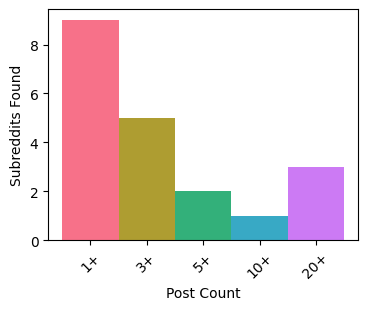

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

top_subreddits = df['postSubreddit'].value_counts().head(20)
top_subreddits_df = top_subreddits.reset_index()
top_subreddits_df.columns = ['Subreddit', 'Number of Posts']

bins = [1, 3, 5, 10, 20, float('inf')]
labels = ['1+', '3+', '5+', '10+', '20+']
top_subreddits_df['Range'] = pd.cut(top_subreddits_df['Number of Posts'], bins=bins, labels=labels, right=False)

range_counts = top_subreddits_df['Range'].value_counts().sort_index()

plt.figure(figsize=(4, 3))
colors = sns.color_palette("husl", len(range_counts))
range_counts.plot(kind='bar', color=colors, width=1)
plt.xlabel('Post Count')
plt.ylabel('Subreddits Found')
plt.xticks(rotation=45)
plt.show()


### Part 4: Simple RAG (for now)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

posts = df[df['postTitle'].notna()]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(
    posts['postTitle'] + " " + 
    posts['postSubreddit']
)

In [9]:
def find_similar_posts(query):
    query_vec = vectorizer.transform([query])
    similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()
    indices = similarity.argsort()[-3:][::-1]
    return df.iloc[indices]

query = "find me reddit posts from slimescholars with posts about slimes"
slimers = find_similar_posts(query)

slimers.head()

,authorId,author,authorProfile,postId,postLink,postTitle,postSubreddit,publishingDate,commentCount,postScore,attachmentType,attachmentLink
1,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1fwjmx0,https://www.reddit.com/r/slimescholars/comment...,Day 1 roster of legendary slimes on Slime Scho...,r/slimescholars,2024-10-05T01:50:56.000000,2.0,5.0,link,/r/slimescholars/comments/1fwjmx0/day_1_roster...
2,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1fwjk17,https://www.reddit.com/r/slimescholars/comment...,"On this day October 5th, 2024 SlimeScholars ha...",r/slimescholars,2024-10-05T01:45:12.000000,2.0,3.0,link,/r/slimescholars/comments/1fwjk17/on_this_day_...
0,t2_21t8gxio,Whalesftw123,https://www.reddit.com/user/Whalesftw123,t3_1gejj8a,https://www.reddit.com/r/China/comments/1gejj8...,What do Chinese citizens think about the 2024 ...,r/China,2024-10-28T21:51:32.000000,140.0,53.0,link,/r/China/comments/1gejj8a/what_do_chinese_citi...


### Part 5: Autogen Integration

In [10]:
import dotenv

from autogen_core.models import UserMessage, AssistantMessage
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

dotenv.load_dotenv()

token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4o-mini",
    model="gpt-4o-mini",
    api_version=dotenv.get_key(dotenv.find_dotenv(), "AZURE_AUTH_API_VERSION"),
    azure_endpoint=dotenv.get_key(dotenv.find_dotenv(), "AZURE_AUTH_API_BASE"),
    api_key=dotenv.get_key(dotenv.find_dotenv(), "AZURE_AUTH_API_KEY")
)

In [14]:
query = """
    if i am the following user, what do i think about slimescholars?
    do you think i would purchase a slimescholars membership? give a specific yes or no answer and provide an explanation?
"""

messages = [
    UserMessage(content=query, source="user"),
    AssistantMessage(content="Attached here are some relevant posts", source="system"),
    AssistantMessage(content=find_similar_posts(query).to_string(), source="system"),
]

response = await client.create(messages=messages)

print(response.content)

Based on the information provided, it appears that you are a user who has shown some interest in the topics related to SlimeScholars, as evidenced by your post activity in the r/slimescholars subreddit. However, without specific details about your views or opinions regarding SlimeScholars, it's difficult to determine your exact feelings. 

Given this context, if I had to choose whether you would purchase a SlimeScholars membership, my answer would be **"No."** 

Explanation: While you have engaged with content related to SlimeScholars, that does not necessarily imply a willingness to invest financially in a membership. Your activities suggest a more casual interest rather than a strong commitment or enthusiasm that typically precedes making a purchase decision.
